In [3]:
import tensorflow as tf
import numpy as np
import tensorflow 
import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tensorflow.keras.models import Model

# CLASS_NAMES = ('Normal', 'Pneumonia', 'COVID-19')
#order of index 

In [4]:
def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model
    

    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str


    Returns 
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = Model(
			inputs=[model.inputs],
			outputs=[model.get_layer(layer_name).output,
				model.output])
    
    with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]
		# use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1]) #making a change here/markup
    heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
    return heatmap

In [5]:
path = '/Users/sumlipuri/Desktop/plant_disease_detection-main/plant_village_denseNet.h5'
model = tf.keras.models.load_model(path)

In [6]:

#predicting the class with our fine tuned densenet169
# probabs1 = model.predict(image1)
# predicted_class1 = np.argmax(probabs1)
all_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and (layer.__class__.__name__ == 'ReLU' or isinstance(layer, tf.keras.layers.Conv2D))]

In [7]:
def single_img(link):
    image = cv2.imread(link)
    imm = []
    image = cv2.resize(image, (256,256))
    image = img_to_array(image)
    imm.append(image)
    return np.array(imm)

In [23]:
path =  '/Users/sumlipuri/Desktop/plant_disease_detection-main/DataSet/color/Grape___healthy/0cfdea92-260f-42b2-9db9-c31fee6ec567___Mt.N.V_HL 6119.JPG'
image1 = single_img(path)
image3d1 = cv2.imread(path)


In [24]:
def apply_gradcam(path):
    image1 = single_img(path)
    image3d1 = cv2.imread(path)
    cams1 = []
    c1 = 0
    for layer in all_layers:
        cam = GradCam(model, image1, layer)
        cam = cv2.resize(cam, (image3d1.shape[1], image3d1.shape[0]))
        # im = tf.stack([cam,cam,cam], axis = -1)
        cams1.append(cam)
        c1 +=1 
    fused_heatmap1 = np.mean(cams1, axis=0)
    return fused_heatmap1

In [25]:
len(all_layers[80:])

40

In [26]:
#applying gradcam to all the layers of our model and fusing them
cams1 = []
c1 = 0
for layer in all_layers[90:]:
    cam = GradCam(model, image1, layer)
    cam = cv2.resize(cam, (image3d1.shape[1], image3d1.shape[0]))
    # im = tf.stack([cam,cam,cam], axis = -1)
    cams1.append(cam)
    c1 +=1 
    print(c1)

fused_heatmap1 = np.mean(cams1, axis=0)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


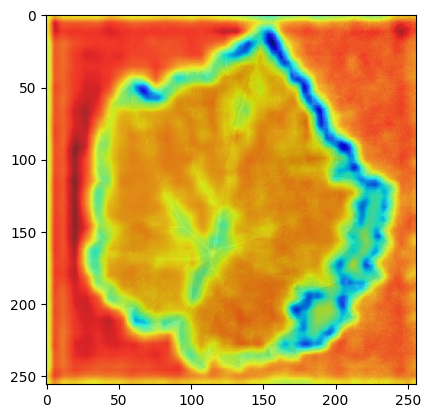

In [30]:
plt.imshow(image3d1)
plt.imshow(fused_heatmap1, cmap= 'jet', alpha= 0.8)
# plt.title(f'Orginal Class {} and Predicted Class {}')